In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import re
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

In [3]:
Dataset_path = "/content/drive/MyDrive/Projects/Audio_Classification/Dataset/recordings"

In [4]:
Labels = []
Samples = []
for filename in os.listdir(Dataset_path):
  file_path = os.path.join(Dataset_path, filename)
  audio_data, sample_rate = librosa.load(file_path, sr=None)
  Labels.append(int(filename[0]))
  Samples.append(audio_data)

In [5]:
Shape_Samples = [Sample.shape for Sample in Samples]
print(f"The highest audio length in all audios is = {np.max(Shape_Samples)}")

The highest audio length in all audios is = 18262


In [6]:
def Audio_Padding (audios, target_length):
  Samples_pad = []
  for audio in audios:
    if len(audio) < target_length:
      # Pad the audio with zeros
      padding = target_length - len(audio)
      audio = np.pad(audio, (0, padding), 'constant')
      Samples_pad.append(audio)
    else:
      Samples_pad.append(audio)
  return Samples_pad

Samples_pad = Audio_Padding(Samples, np.max(Shape_Samples))

In [7]:
Samples_pad = np.array(Samples_pad)
Labels = np.array(Labels)

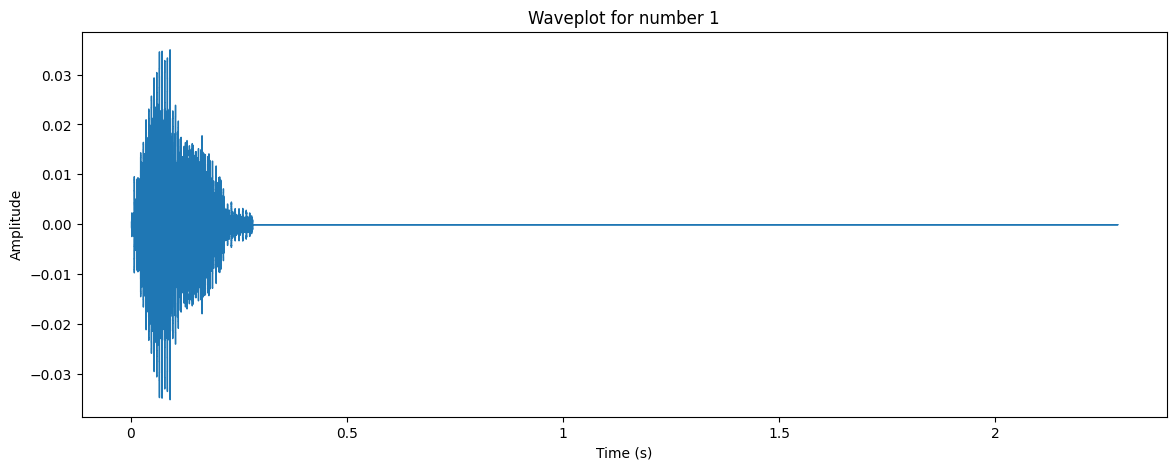

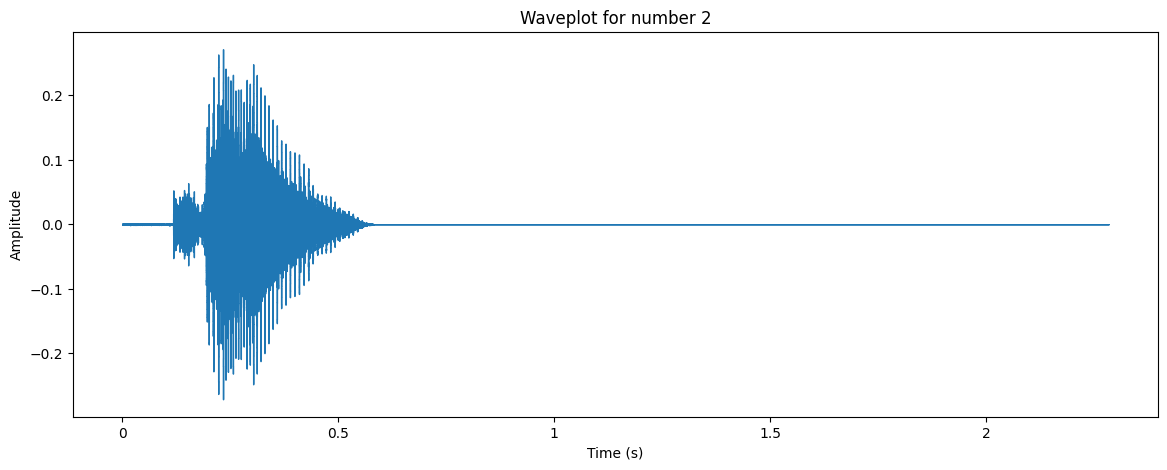

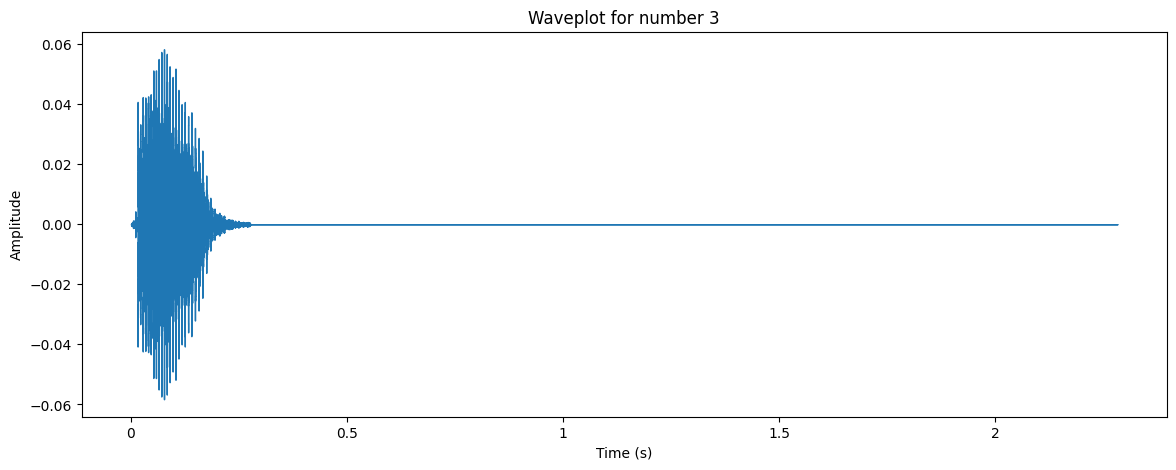

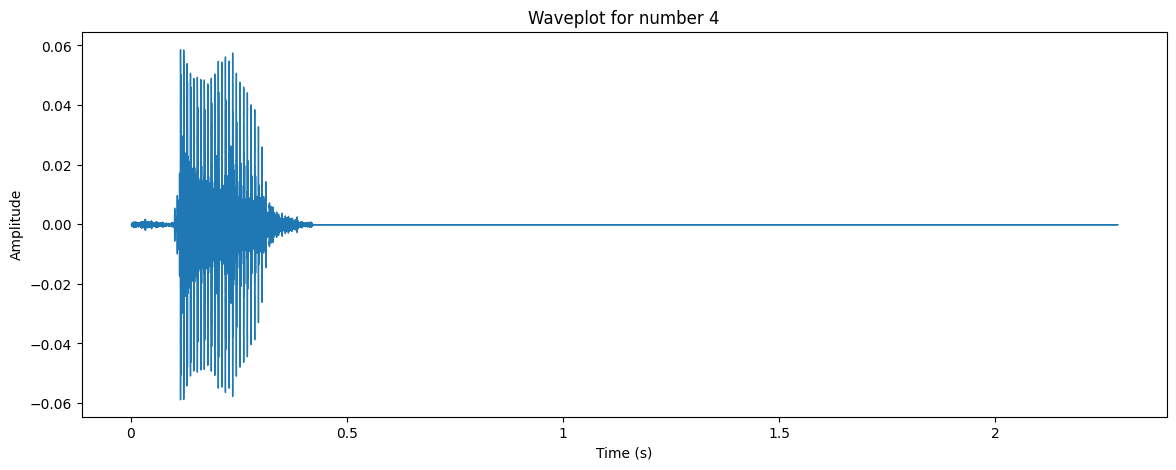

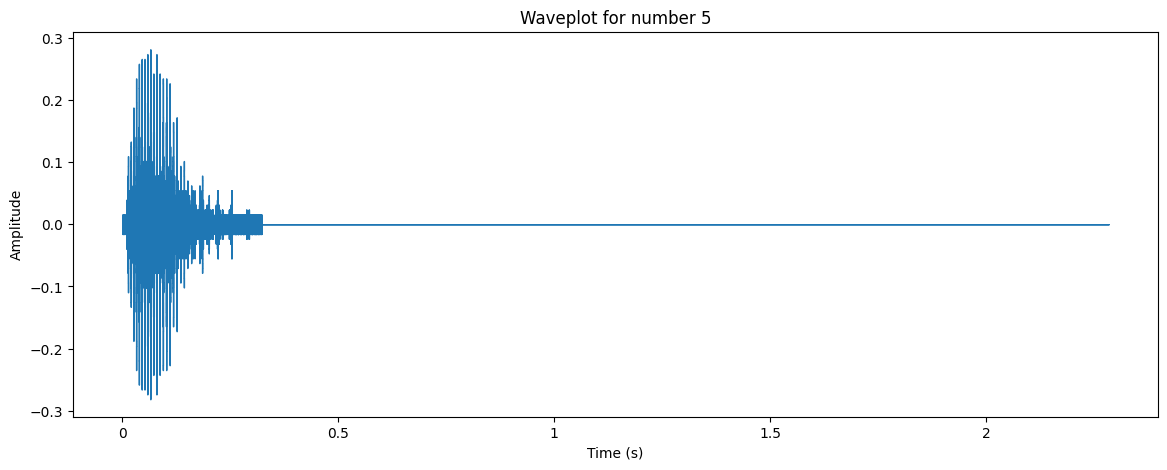

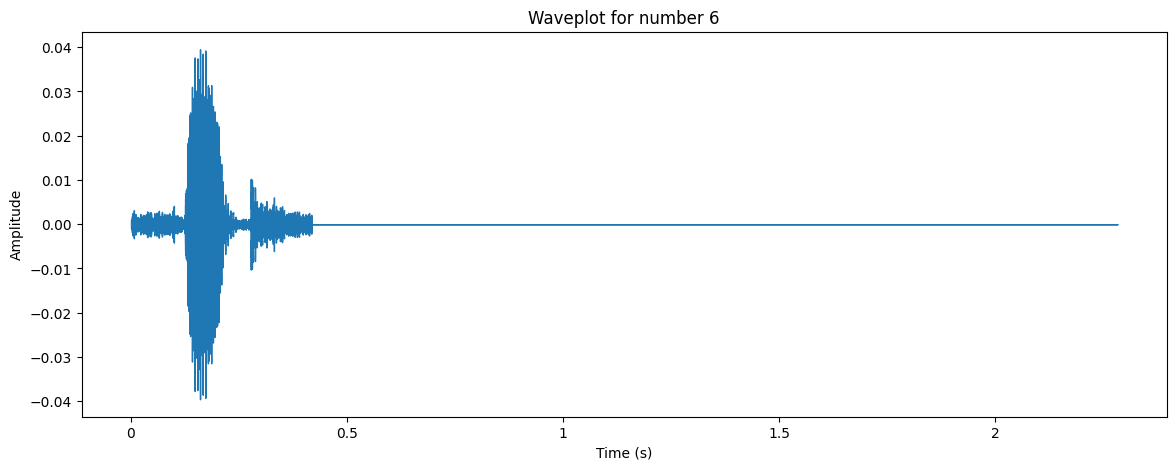

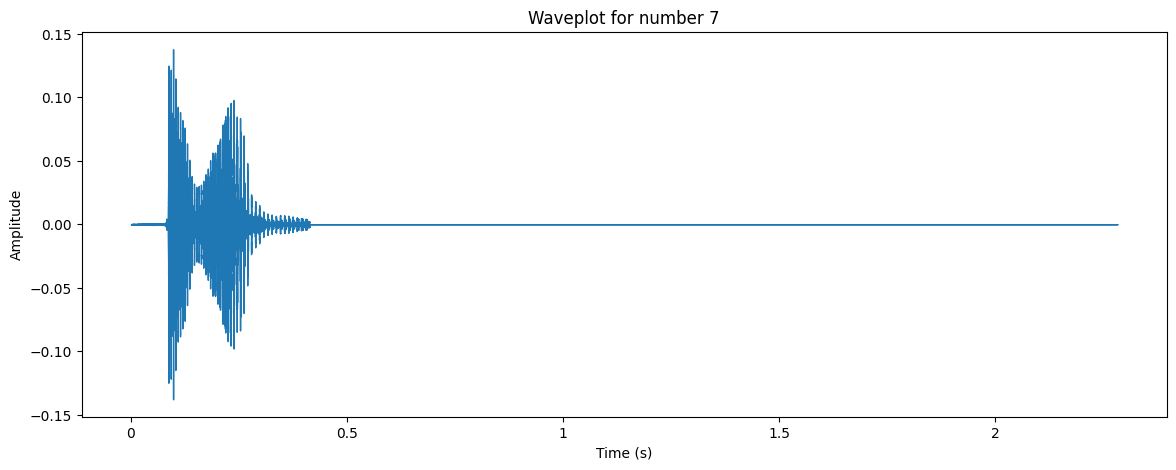

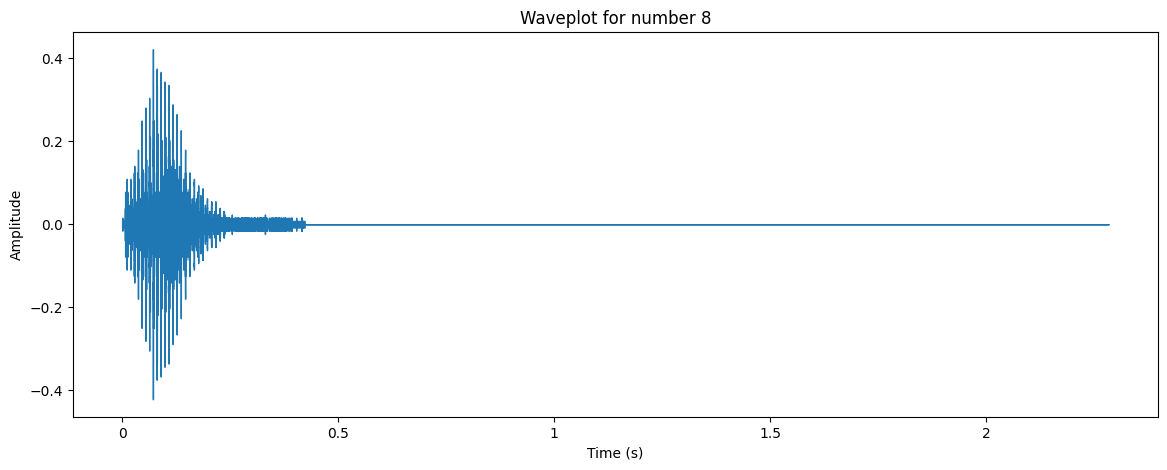

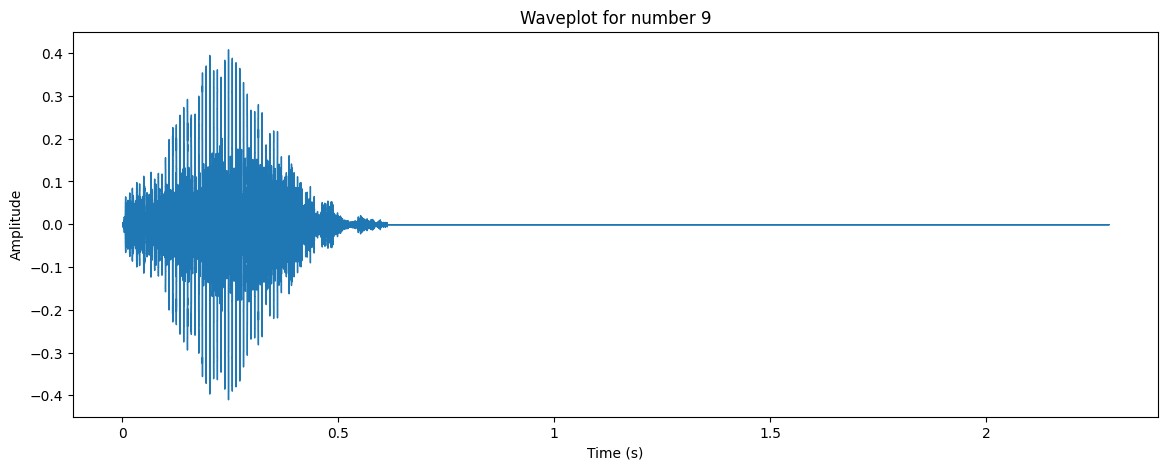

In [8]:
ind_class = [np.where(Labels == i)[0][0] for i in range(1, 10)]
for count, i in enumerate(ind_class):
  plt.figure(figsize=(14, 5))
  librosa.display.waveshow(Samples_pad[i], sr=sample_rate)
  plt.title(f'Waveplot for number {count+1}')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.show()

In [9]:
Samples_pad.shape, Labels.shape

((3000, 18262), (3000,))

In [10]:
def Audio_to_Mel_Spectrogram(Audios):
  Mel_Spectrograms = []
  for audio in Audios:
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=8000, n_mels=128, fmax=4000)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    Mel_Spectrograms.append(mel_spectrogram_db)
  return np.array(Mel_Spectrograms)


Samples_mel_spec = Audio_to_Mel_Spectrogram(Samples_pad)

In [11]:
Samples_mel_spec.shape, Labels.shape

((3000, 128, 36), (3000,))

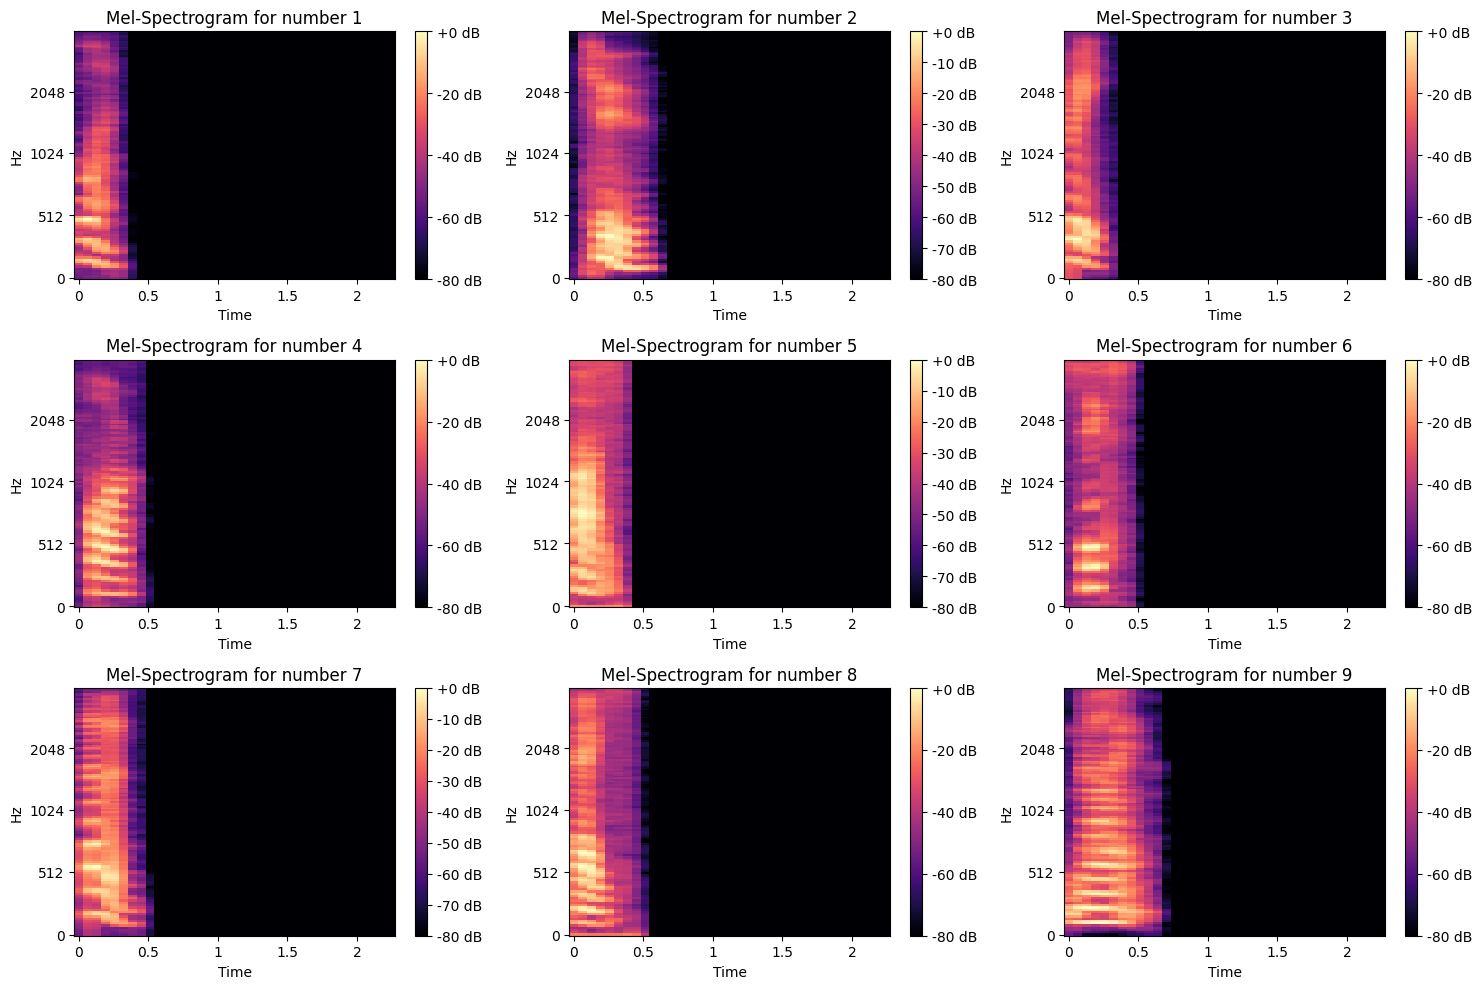

In [12]:
ind_class = [np.where(Labels == i)[0][0] for i in range(1, 10)]
plt.figure(figsize=(15, 10))
for count, i in enumerate(ind_class):
  plt.subplot(3, 3, count+1)
  librosa.display.specshow(Samples_mel_spec[i], sr=8000, x_axis='time', y_axis='mel', fmax=4000)
  plt.colorbar(format='%+2.0f dB')
  plt.title(f'Mel-Spectrogram for number {count+1}')
plt.tight_layout()
plt.show()


In [13]:
Original_shape = Samples_mel_spec.shape
Samples_mel_spec = Samples_mel_spec.reshape(Samples_mel_spec.shape[0], -1)
sc = MinMaxScaler((-1, 1))
Samples_mel_spec_scaled = sc.fit_transform(Samples_mel_spec)
Samples_mel_spec_scaled = Samples_mel_spec_scaled.reshape(Original_shape)

In [14]:
X_train_sepc, X_test_spec, X_train_aud, X_test_aud, y_train, y_test = train_test_split(Samples_mel_spec_scaled, Samples_pad, Labels, test_size = 0.2, random_state = 42)

In [15]:
print(f"The shape of X_train_sepc is = {X_train_sepc.shape}")
print(f"The shape of X_train_aud is = {X_train_aud.shape}")
print(f"The shape of X_test_spec is = {X_test_spec.shape}")
print(f"The shape of X_test_aud is = {X_test_aud.shape}")

The shape of X_train_sepc is = (2400, 128, 36)
The shape of X_train_aud is = (2400, 18262)
The shape of X_test_spec is = (600, 128, 36)
The shape of X_test_aud is = (600, 18262)


In [16]:
class Maximum(tf.keras.Layer):
    def call(self, x1, x2):
        return tf.maximum(x1, x2)

def Create_Model(input_shape_spec, input_shape_aud, EfficientNetB0_model):
  input_layer_spec = Input(shape=input_shape_spec, name = "Input 1")
  input_layer_aud = Input(shape=input_shape_aud, name = "Input 2")

  # First input block
  x1 = Conv2D(3, (3, 3), padding='same', name = "Conv2DBayan")(input_layer_spec)  # Convert 1 channel to 3 channels
  x1 = EfficientNetB0_model(x1)
  x1 = MaxPooling2D()(x1)
  x1 = Flatten()(x1)
  x1 = Dense(256, activation='relu')(x1)
  x1 = Dropout(0.2)(x1)
  x1 = BatchNormalization()(x1)
  x1 = Dense(128, activation='relu')(x1)
  x1 = Dropout(0.2)(x1)
  x1 = BatchNormalization()(x1)
  x1 = Dense(64, activation='relu')(x1)
  x1 = Dropout(0.2)(x1)
  x1 = BatchNormalization()(x1)
  x1 = Dense(32, activation='relu')(x1)
  x1 = Dropout(0.2)(x1)

  # Second input block
  x2 = Dense(256, activation='tanh')(input_layer_aud)
  x2 = Dropout(0.2)(x2)
  x2 = BatchNormalization()(x2)
  x2 = Dense(128, activation='tanh')(x2)
  x2 = Dropout(0.2)(x2)
  x2 = BatchNormalization()(x2)
  x2 = Dense(64, activation='tanh')(x2)
  x2 = Dropout(0.2)(x2)
  x2 = BatchNormalization()(x2)
  x2 = Dense(32, activation='tanh')(x2)
  x2 = Dropout(0.2)(x2)

  x = Maximum()(x1, x2)
  output_layer = Dense(10, activation='softmax')(x)
  model = Model(inputs=(input_layer_spec, input_layer_aud), outputs=output_layer)
  return model

EfficientNetB0_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 36, 3))
model = Create_Model((X_train_sepc.shape[1], X_train_sepc.shape[2], 1), (X_train_aud.shape[1], ), EfficientNetB0_model)
Opt = Adam(learning_rate=0.001)
model.compile(optimizer = Opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input 1 (InputLayer)      │ (None, 128, 36, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2DBayan (Conv2D)      │ (None, 128, 36, 3)     │             30 │ Input 1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 4, 2, 1280)     │      4,049,571 │ Conv2DBayan[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 2, 1, 1280)     │              0 │ efficientnetb0[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2560)           │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Input 2 (InputLayer)      │ (None, 18262)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        655,616 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │      4,675,328 │ Input 2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 256)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256)            │          1,024 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256)            │          1,024 │ dropout_4[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         32,896 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 128)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128)            │            512 │ dropout_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 9,470,923 (36.13 MB)

 Trainable params: 9,427,108 (35.96 MB)

 Non-trainable params: 43,815 (171.16 KB)

In [ ]:
hist = model.fit((X_train_sepc, X_train_aud), y_train, validation_split = 0.2, epochs = 500, batch_size = 128)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.1176 - loss: 2.6589 - val_accuracy: 0.1292 - val_loss: 2.3063
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - accuracy: 0.1797 - loss: 2.3123 - val_accuracy: 0.1208 - val_loss: 2.3199
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.2553 - loss: 2.0934 - val_accuracy: 0.1167 - val_loss: 2.3106
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.3517 - loss: 1.8551 - val_accuracy: 0.1250 - val_loss: 2.3362
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.4986 - loss: 1.5618 - val_accuracy: 0.1187 - val_loss: 2.3177
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.5854 - loss: 1.2993 - val_accuracy: 0.1104 - val_loss: 2.3840
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7284 - loss: 0.9810 - val_accuracy: 0.0833 - val_loss: 2.7498
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8166 - loss: 0.7460 - val_accuracy:

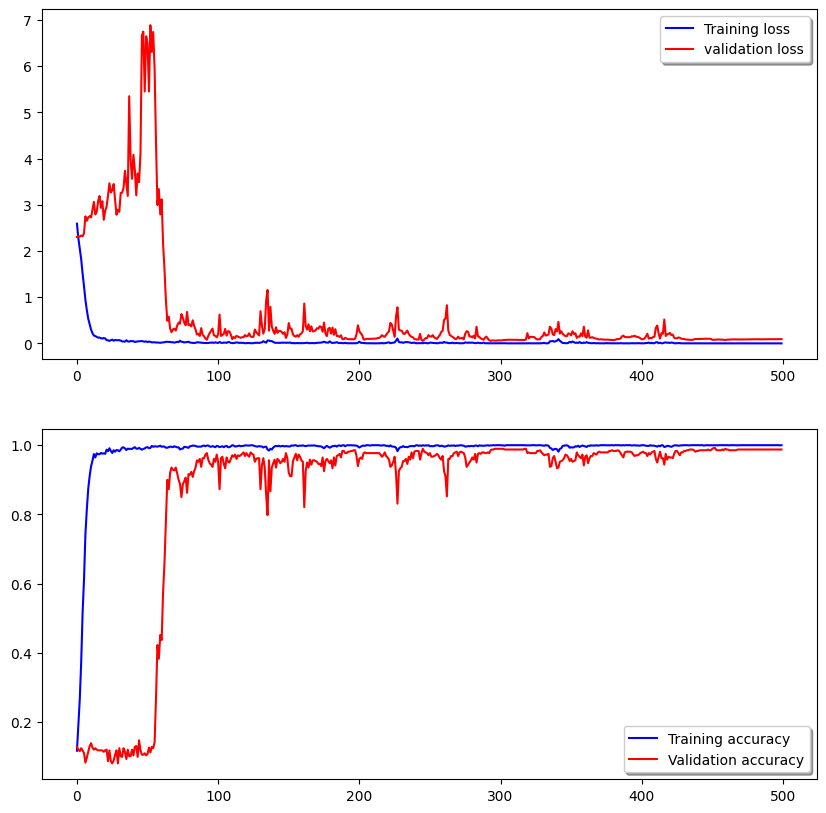

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


In [17]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Projects/Audio_Classification/best_model.h5", custom_objects={'Maximum': Maximum})

In [18]:
y_pred = model.predict((X_test_spec, X_test_aud))
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes, digits = 4))

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 379ms/step
              precision    recall  f1-score   support

           0     0.9851    1.0000    0.9925        66
           1     0.9808    1.0000    0.9903        51
           2     0.9661    1.0000    0.9828        57
           3     0.9841    0.9841    0.9841        63
           4     1.0000    1.0000    1.0000        61
           5     1.0000    0.9815    0.9907        54
           6     0.9853    0.9853    0.9853        68
           7     1.0000    0.9649    0.9821        57
           8     1.0000    1.0000    1.0000        63
           9     1.0000    0.9833    0.9916        60

    accuracy                         0.9900       600
   macro avg     0.9901    0.9899    0.9899       600
weighted avg     0.9902    0.9900    0.9900       600



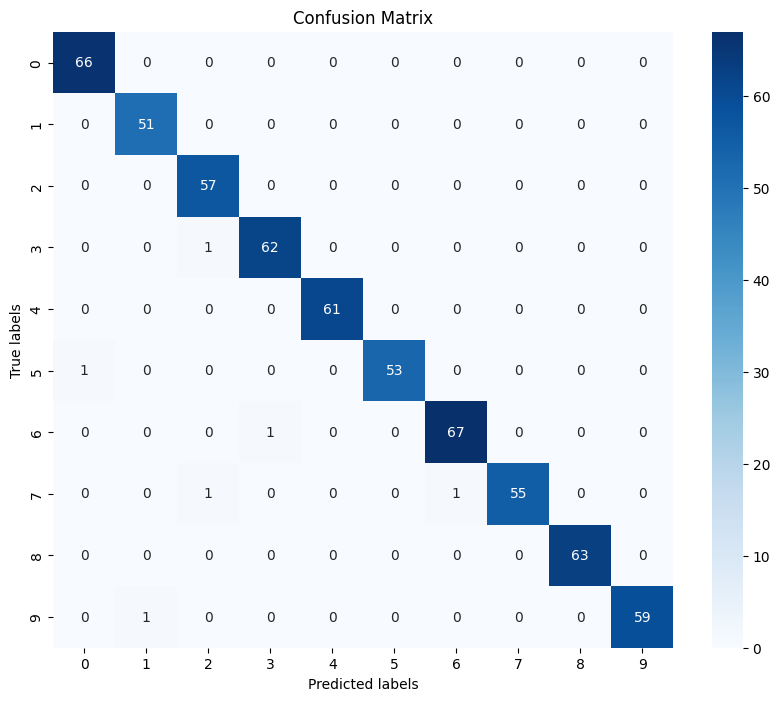

In [19]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()